We will now make use of the compressed tflite model that we have obtained in the previous section and design our final pipeline, that is from getting an image (as a file on the disk) to obtain a text file (also as file on the disk)

In [31]:
# importing dependencies
import os
import re
import numpy as np
import csv
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from time import strftime
import pytesseract
import tensorflow as tf
from tensorflow.keras import Model
import img2pdf

In [116]:
# defining helper functions 
def load_interpreter(model_path=None):
    """
    This function loads a tflite model interpreter 
    """
    if model_path is None:
        model_path = os.path.sep.join(['C:\\Users\\AkshayPatil\\Desktop\\Falcon\\PDF_OCR', 'tablenet_densenet121_lite.tflite'])
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    return interpreter 

def adjust(new_rows, maxi):
    """
    A function to set all with maxi number of columns
    for making csv compatible
    """
    rows = []
    for each_row in new_rows:
        if len(each_row) < maxi:
            for i in range(maxi - len(each_row)):
                each_row.append("-")
        rows.append(each_row)
    return rows

def text2csv(text):
    """
    This funtion transorms a text with newline and spaces to
    a csv that treats the spaces in the text as comma and newlines as carriage return
    """
    rows = text.split('\n')
    new_rows = []
    maxi = 0
    for each_row in rows:
        temp_row = each_row.split()
        if maxi < len(temp_row):
            maxi = len(temp_row)
        new_rows.append(temp_row)
    new_rows = adjust(new_rows, maxi)
    header = ['column_{}'.format(i) for i in range(maxi)]
    tstr = strftime("%Y%m%d-%H%M")
    temp_dir = os.path.join('output', 'temporary_files')
    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)
    temp_file = os.path.join(temp_dir, 'temp_{}.csv'.format(tstr))

    with open(temp_file, 'w') as f:
        csvwriter = csv.writer(f)
        csvwriter.writerow(header)
        csvwriter.writerows(new_rows)
    return temp_file

def append_offset(name, offset):
    """
    This function is used for assigning a name with offset if a file with the same name exists
    It takes a filename and a offset and returns a valid equivalent name with offset number
    
    Example :
    # assume two variables 
    name = 'python.py'
    offset = '2'
    append_offset(name, offset)
    
    # The above invocation will return string as
    # 'python_2.py'
    """
    fname, extension = name.split('.')
    fname = ''.join([fname, '_', offset, '.', extension])
    return fname

def render(mask):
  mask = tf.argmax(mask, axis=-1)
  mask = mask[..., tf.newaxis]
  return mask[0]

def visualize(image):
    plt.figure(figsize=(15, 15))
    title = 'Cropped Image'
    plt.title(title)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
    plt.axis('off')
    plt.show()

In [117]:
pytesseract.pytesseract.tesseract_cmd = "C:\\Program Files\\Tesseract-OCR\\tesseract.exe"

def final(img_path, output_dir='temp_output', show_table=False):
    
    interpreter = load_interpreter()
    image_orig = Image.open(img_path)
    original_dim = image_orig.size
    image = image_orig.resize((512,512))
    np_image = np.asarray(image)/255.0
    np_image = np_image.astype(np.float32)
    np_image = np.expand_dims(np_image, axis=0)

    ip_d = interpreter.get_input_details()[0]
    op_d = interpreter.get_output_details()[0]

    interpreter.set_tensor(ip_d['index'], np_image)
    interpreter.invoke()
    
    tab_mask = interpreter.get_tensor(op_d['index'])

    
    tab_mask = np.squeeze(render(tab_mask).numpy())

    tab_mask = Image.fromarray(np.uint8(tab_mask))
    tab_mask = tab_mask.resize(original_dim)

    tab_mask = np.array(tab_mask)

    image_orig = image_orig
    x, y, w, h = cv2.boundingRect(tab_mask)
    # x = 0
    # y = 0
    # w = 2975
    # h = 3850
    tab = image_orig.crop((x, y, x+w, y+h))
    # print(tab)
    tab.save('cropped_img.jpg')
    # Convert image to pdf
    imagepdf = Image.open('C:\\Users\\AkshayPatil\\Desktop\\Falcon\\PDF_OCR\\cropped_img.jpg')
    pdf_bytes = img2pdf.convert(imagepdf.filename)
    file = open("origimage_pdf.pdf", "wb")
    file.write(pdf_bytes)
    imagepdf.close()
    file.close()
    print("Successfully made pdf file")

    text = pytesseract.image_to_string(tab)
    # image_to_boxes result:  x coordinate, y coordinate, diagonal point of x coordinate, diagonal point of y coordinate
    lines = pytesseract.image_to_boxes(tab)
    print('text', text)
    print('x coordinate, y coordinate, diagonal point of x coordinate, diagonal point of y coordinate', lines)
    text = text.strip()
    text = re.sub("[\r\n]+", "\r\n", text)
    # image_to_data result: left/top/width/height：the top-left coordinate and the width and height of the current word.
    
    coord = pytesseract.image_to_data(tab)
        
    with open('coord.txt', 'w') as coo:
        coo.writelines(coord)
    print('left/top/width/height：the top-left coordinate and the width and height of the current word.\n', coord)
    csv = text2csv(text)
    csv_fname = img_path.split(os.path.sep)[-1].replace('png', 'csv')
    dest_dir = os.path.join(output_dir)
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    dest = os.path.join(dest_dir, csv_fname)
    with open('readme.txt', 'w') as f:
        f.writelines(text)
    # if file already exists in the temp directory it will save the csv 
    # by appending some offset to the filename before extension
    try:
        os.rename(csv, dest)
    except:
        f_save = 'fail'
        i=2
        while(f_save=='fail'):
            name_off = str(i)
            try:
                dest = os.path.join(dest_dir, append_offset(csv_fname,name_off))
                os.rename(csv, dest)
                f_save = 'pass'
            except:
                i += 1

    if show_table:
        visualize(tab)

    return dest

Inference using the final function

Successfully made pdf file
text HISPOCTIOHL yale, UF fUOI ZU ZU

Owner Information

Jwner Name: CASSANDRA V LORD &H DERRICK LORD Contact Person:
Address: 11330 SW 246th St, Home Phone:

“ity: Homestead, Zip: 33032 Work Phone:

nsurance Company: Policy #:

Year of Home: 2003 # of Stories: One (1) Email:

NOTE: Any documentation used in validating the compliance or existence of each construction or mitigation attribute must
accompany this form. At least one photograph must accompany this form to validate each attribute marked in questions 3
‘hough 7. The insurer may ask additional questions regarding the mitigated feature(s) verified on this form.

|. Building Code: Was the structure built in compliance with the Florida Building Code (FBC 2001 or later) OR for homes locate
the HVHZ (Miami-Dade or Broward counties), South Florida Building Code (SFBC-94)?

A. Built in compliance with the FBC: Year Built 2003 . For homes built in 2002/2003 provide a permit application w
a date after 3/1/200

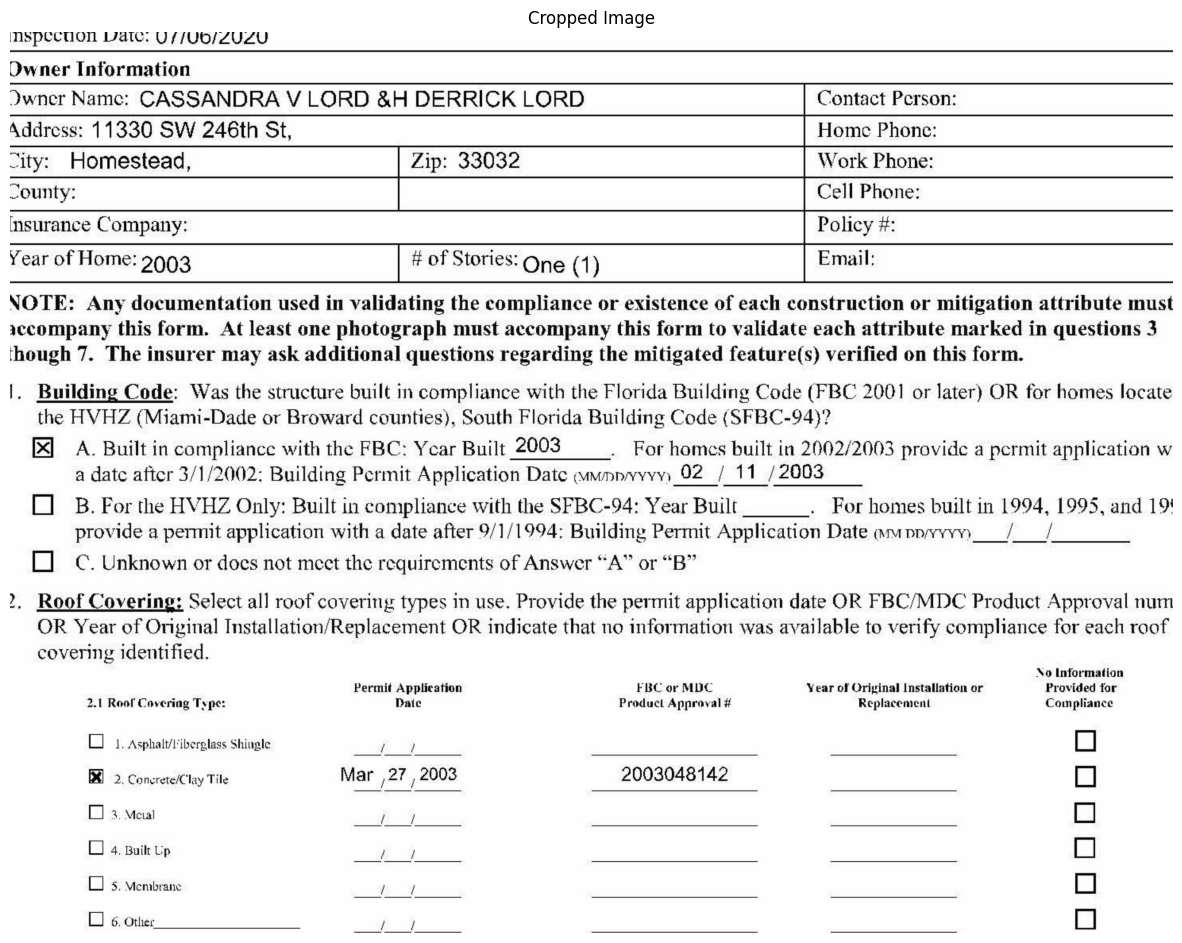

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21
0,HISPOCTIOHL,"yale,",UF,fUOI,ZU,ZU,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
1,Owner,Information,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
2,Jwner,Name:,CASSANDRA,V,LORD,&H,DERRICK,LORD,Contact,Person:,...,-,-,-,-,-,-,-,-,-,-
3,Address:,11330,SW,246th,"St,",Home,Phone:,-,-,-,...,-,-,-,-,-,-,-,-,-,-
4,ity:,"Homestead,",Zip:,33032,Work,Phone:,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
5,nsurance,Company:,Policy,#:,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
6,Year,of,Home:,2003,#,of,Stories:,One,(1),Email:,...,-,-,-,-,-,-,-,-,-,-
7,NOTE:,Any,documentation,used,in,validating,the,compliance,or,existence,...,construction,or,mitigation,attribute,must,-,-,-,-,-
8,accompany,this,form.,At,least,one,photograph,must,accompany,this,...,validate,each,attribute,marked,in,questions,3,-,-,-
9,hough,7.,The,insurer,may,ask,additional,questions,regarding,the,...,verified,on,this,form.,-,-,-,-,-,-


In [120]:
img_path = 'C:\\Users\\AkshayPatil\\Desktop\\Falcon\\PDF_OCR\\Scanned_images\\Images\\Page_2.jpg'
csv_path = final(img_path, show_table=True)
df = pd.read_csv(csv_path, encoding= 'unicode_escape')
df.to_csv('output_1.csv')
df

In [119]:
# opening and creating new .txt file and removing unwanted whitespaces
with open("readme.txt", 'r') as r, open('readmeupdated.txt', 'w') as o:
    for line in r:
        #strip() function
        if line.strip():
            o.write(line)
f = open("readmeupdated.txt", "r")
#print("New text file:\n",f.read())

Using Connected components with Stats function

In [ ]:
src = cv2.imread("C:\\Users\\AkshayPatil\\Desktop\\Falcon\\PDF_OCR\\cropped_img.jpg", 1)
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
# binary_map = (src > 0).astype(np.uint8)
connectivity = 4 # or whatever you prefer

output = cv2.connectedComponentsWithStats(thresh, connectivity, cv2.CV_32S)
(numLabels, labels, stats, centroids) = output

for i in range(len(stats)):
    x, y, w, h, area = stats[i]
    (cX, cY) = centroids[i]
    print(stats[i])
    output = src.copy()
    cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
    cv2.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)
    componentMask = (labels == i).astype("uint8") * 255
    
    plt.figure(figsize=(15, 15))
    title = 'Output'
    plt.title(title)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(output))
    plt.axis('off')
    plt.show()
    
    plt.figure(figsize=(15, 15))
    title = 'Connected Component'
    plt.title(title)
    plt.imshow(componentMask)
    plt.axis('off')
    plt.show()